In [66]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score
import dask_ml
import dask
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import QuantileTransformer

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Sending large graph.*")

from dask.distributed import Client, LocalCluster
import dask.multiprocessing

cluster = LocalCluster(processes=True,n_workers=6, threads_per_worker=1)
client = Client(cluster)
import sys
import pickle 

from data_helpers import *
from metrics import *

/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55315 instead
  warnings.warn(


In [104]:
cluster = LocalCluster(processes=True,n_workers=6, threads_per_worker=1)
client = Client(cluster)

/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50483 instead
  warnings.warn(


In [3]:
folders = [
    'train0_25',
    'train25_50',
    'train50_75',
    'train75_100'
]

# Read Parquet files from each folder into Dask DataFrames
dfs = [dd.read_parquet(folder) for folder in folders]

# Concatenate all DataFrames into a single DataFrame
data = dd.concat(dfs)

In [4]:
np.random.seed(42)

orig_partitions = [i for i in range(0,int(data.npartitions))]
np.random.shuffle(orig_partitions) #shuffles inplace

trainSep = int(0.7* data.npartitions)
valEnd = data.npartitions #int(0.05* data.npartitions) + trainSep

sampledPartIdxTrain = orig_partitions[0:trainSep]
sampledPartIdxTest  = orig_partitions[trainSep:valEnd]

# min Values

In [34]:
minDict = {} #minimum value that is not 0
for f in allT2: #['ptend_q0001_26','ptend_q0002_26']:#transfTarg60: #allT:
    a = data[f].compute()
    hasPos = max(a)>0
    hasNeg = min(a)<0
    minNeg = min(abs(a.loc[a < 0])) if hasNeg else 1e10
    minPos = min(abs(a.loc[a > 0])) if hasPos else 1e10
    maxPos = max(a)
    maxNeg = abs(min(a))
    minDict[f] = {'minNeg':minNeg, 'minPos':minPos, 'min':min(minNeg,minPos), 'maxPos':maxPos, 'maxNeg':maxNeg, 'max':max(maxPos, maxNeg)}

2024-07-05 14:25:39,544 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:51988 -> tcp://127.0.0.1:51905
Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 1124, in write_to_fd
    return self.socket.send(data)  # type: ignore
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/comm/tcp.py", line 236, in read
    convert

In [35]:
with open('minVal_allT2.pkl', 'wb') as f:
    pickle.dump(minDict, f)    

In [5]:
with open('minVal_ptend_q0002_26.pkl', 'rb') as f:
    minDict = pickle.load(f)

# data setup

In [105]:
train = data.partitions[sampledPartIdxTrain[0:15]].compute()
#largeV = pd.read_csv('large_ptend_q0002_26.csv')
largeV = pd.read_parquet('large_training_df_0001')
train = pd.concat([train,largeV], axis = 0)

#with all large values: -> way worse log transform performance
#                       -> quantile transf is stable, can't fit training well / too extreme

2024-07-05 17:04:25,120 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:50519 -> tcp://127.0.0.1:50520
Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/tornado/iostream.py", line 1124, in write_to_fd
    return self.socket.send(data)  # type: ignore
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/comm/tcp.py", line 236, in read
    convert

In [24]:
val = data.partitions[sampledPartIdxTest[15:30]].compute()

# LGBM for ptend_q0002_26 & log transf
- looks really good with log transform + weight
- quantile transform + weight has a hard time resolving extreme values - not as good

In [47]:
f = 'ptend_q0002_26'
minValue = minDict[f]['min']
transfF = f+'_transf'
train[transfF] = custom_log(train[f].copy(), minValue=minValue)
val[transfF] = custom_log(val[f].copy(), minValue=minValue)

In [48]:
valSet = lgb.Dataset(val[allF], label=val[transfF], free_raw_data=False)
trainSet = lgb.Dataset(train[allF], train[transfF], weight=train['weight'], free_raw_data=False)

In [49]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    #'num_leaves': 15,
    #'learning_rate': 0.05,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': 1
}


gbm = None #lgb.Booster(model_file=fileName) if i != 0 else None

gbm = lgb.train(params,
            trainSet,
            num_boost_round=200, 
            valid_sets=valSet,
            init_model=gbm)

predTrain0 = gbm.predict(train[allF])
predVal0 = gbm.predict(val[allF])
predTrain = inv_custom_log(predTrain0, minDict[f]['min'])
predVal = inv_custom_log(predVal0, minDict[f]['min'])
r2train =r2_score(train[f], predTrain)
r2test =r2_score(val[f], predVal)
print('r2 scores', r2train,r2test, 'transormed',r2_score(train[transfF], predTrain0),r2_score(val[transfF], predVal0))



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112639
[LightGBM] [Info] Number of data points in the train set: 55763, number of used features: 483
[LightGBM] [Info] Start training from score 95.129773
r2 scores 0.9967323502537448 0.9732626789677309 transormed 0.956165663094236 0.8994152117456726


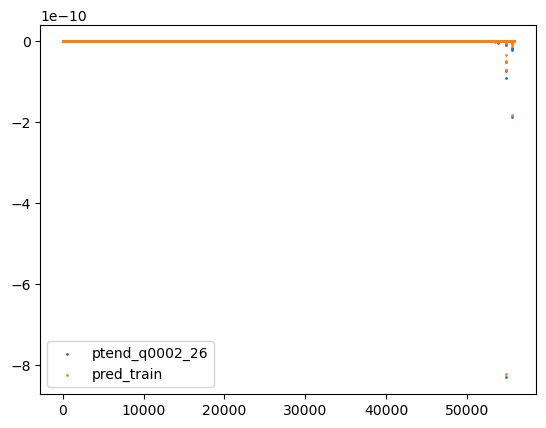

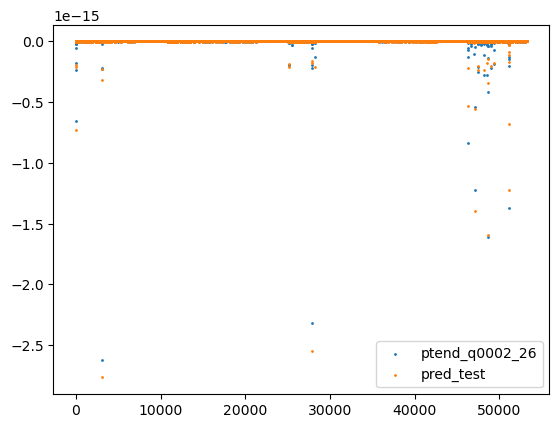

In [50]:
""" in feature space """
plt.scatter(x=range(train.shape[0]),y=train[f], s=1,label=f)
plt.scatter(x=range(train.shape[0]),y=predTrain, s=1,label='pred_train')
plt.legend()
plt.show()

plt.scatter(x=range(val.shape[0]),y=val[f], s=1,label=f)
plt.scatter(x=range(val.shape[0]),y=predVal, s=1,label='pred_test')
plt.legend()
plt.show()

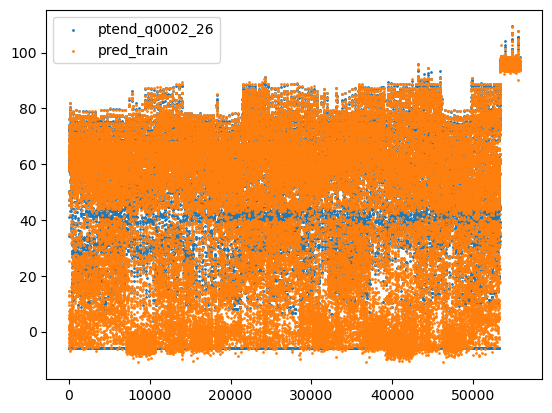

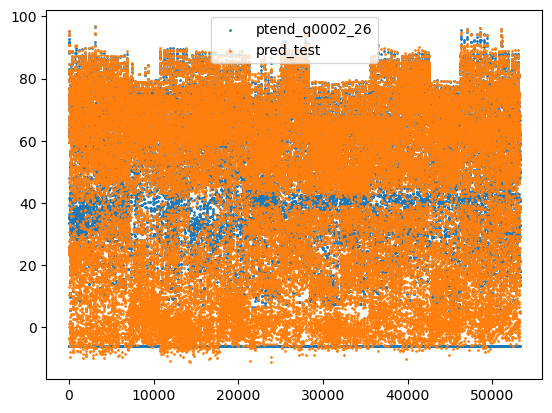

In [51]:
""" in transformed space """
plt.scatter(x=range(train.shape[0]),y=train[transfF], s=1,label=f)
plt.scatter(x=range(train.shape[0]),y=predTrain0, s=1,label='pred_train')
plt.legend()
plt.show()

plt.scatter(x=range(val.shape[0]),y=val[transfF], s=1,label=f)
plt.scatter(x=range(val.shape[0]),y=predVal0, s=1,label='pred_test')
plt.legend()
plt.show()

In [41]:
predTrain0 = gbm.predict(train[allF])
predVal0 = gbm.predict(val[allF])
predTrain = inv_custom_log(predTrain0, minDict[f]['min'])
predVal = inv_custom_log(predVal0, minDict[f]['min'])
r2train =r2_score(train[f], predTrain)
r2test =r2_score(val[f], predVal)
print('r2 scores', r2train,r2test, 'transormed',r2_score(train[transfF], predTrain0),r2_score(val[transfF], predVal0))

r2 scores -1.21697529478187e+20 -1.4069667468811415e+20 transormed 0.681682080588083 0.6349711760213259


# lgbm for ptend_q0002_55
- distribution gets all fucked up with custom log

In [116]:
f = 'ptend_q0002_55'
minValue = minDict[f]['min']
transfF = f+'_transf'
train[transfF] = custom_log(train[f].copy(), minValue=minValue)
val[transfF] = custom_log(val[f].copy(), minValue=minValue)

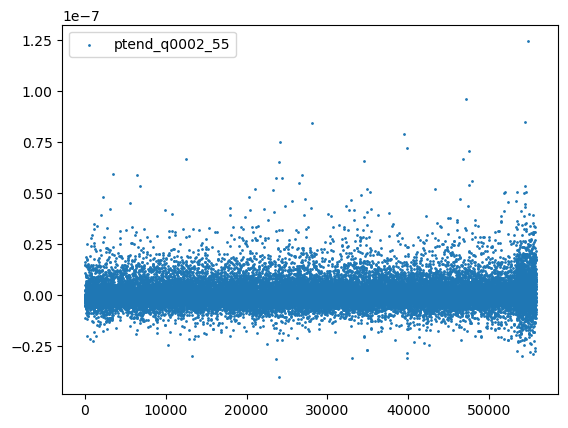

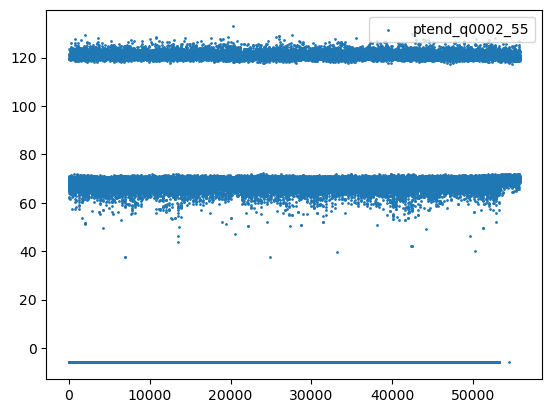

In [57]:
plt.scatter(x=range(train.shape[0]),y=train[f], s=1,label=f)
plt.legend()
plt.show()

plt.scatter(x=range(train.shape[0]),y=train[transfF], s=1,label=f)
plt.legend()
plt.show()

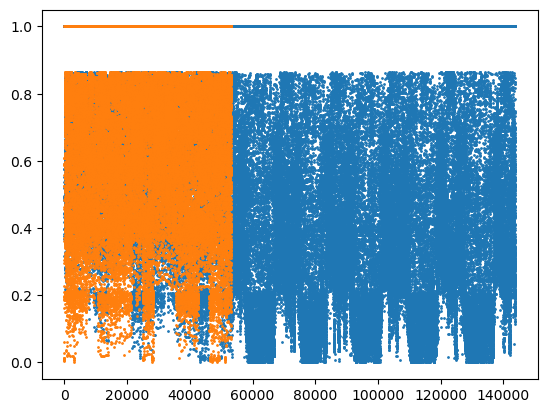

In [111]:
qt = QuantileTransformer(n_quantiles=10000, random_state=0, output_distribution='uniform')
train[transfF] = qt.fit_transform(train[[f]])
val[transfF] = qt.transform(val[[f]])

fig = plt.figure()
plt.scatter(x=range(0,train.shape[0]), y=train[transfF], s=1)
plt.scatter(x=range(0,val.shape[0]), y=val[transfF], s=1)

In [79]:
qt.inverse_transform(np.reshape(val[transfF],(-1,1))), val[f]

/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


(array([[-5.62902651e-10],
        [-4.20463360e-10],
        [-8.71243894e-10],
        ...,
        [ 8.27610025e-09],
        [-2.90447234e-09],
        [ 7.55183838e-09]]),
 0      -5.629027e-10
 1      -4.204634e-10
 2      -8.712439e-10
 3       1.121222e-09
 4      -3.762434e-10
             ...     
 3544    6.236870e-09
 3545   -4.244225e-09
 3546    8.276100e-09
 3547   -2.904472e-09
 3548    7.551838e-09
 Name: ptend_q0002_55, Length: 53261, dtype: float64)

In [74]:
"""------ BASE -----"""
valSet = lgb.Dataset(val[allF], label=val[f], free_raw_data=False)
trainSet = lgb.Dataset(train[allF], train[f])#, weight=train['weight'], free_raw_data=False)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    #'num_leaves': 15,
    #'learning_rate': 0.05,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': 1
}


gbm = None #lgb.Booster(model_file=fileName) if i != 0 else None

gbm = lgb.train(params,
            trainSet,
            num_boost_round=200, 
            valid_sets=valSet,
            init_model=gbm)

predTrain = gbm.predict(train[allF])
predVal = gbm.predict(val[allF])
r2train =r2_score(train[f], predTrain)
r2test =r2_score(val[f], predVal)
print('r2 scores', r2train,r2test, 'transormed')

KeyboardInterrupt: 

In [117]:
"""------ transformed test -----"""
valSet = lgb.Dataset(val[allF], label=val[transfF], free_raw_data=False)

trainSet = lgb.Dataset(train[allF], label=train[transfF], weight=train['weight'], free_raw_data=False)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    #'num_leaves': 15,
    #'learning_rate': 0.05,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': 1
}


gbm = None #lgb.Booster(model_file=fileName) if i != 0 else None

gbm = lgb.train(params,
            trainSet,
            num_boost_round=200, 
            valid_sets=valSet,
            #callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)],
            init_model=gbm)

predTrain0 = gbm.predict(train[allF])
predVal0 = gbm.predict(val[allF])
predTrain = qt.inverse_transform(np.reshape(predTrain0,(-1,1)))
predVal = qt.inverse_transform(np.reshape(predVal0,(-1,1)))
r2train =r2_score(train[f], predTrain)
r2test =r2_score(val[f], predVal)
print('r2 scores', r2train,r2test, 'transormed',r2_score(train[transfF], predTrain0),r2_score(val[transfF], predVal0))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.446025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112697
[LightGBM] [Info] Number of data points in the train set: 143800, number of used features: 484
[LightGBM] [Info] Start training from score 90.838421
r2 scores -0.023501708184689107 -0.00020862493579465458 transormed 0.6203413379793141 0.6370886140887483


/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


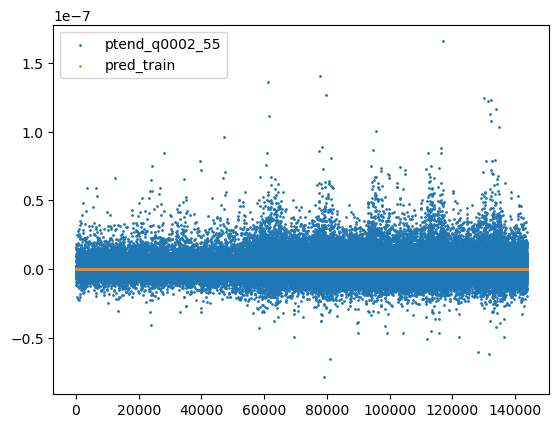

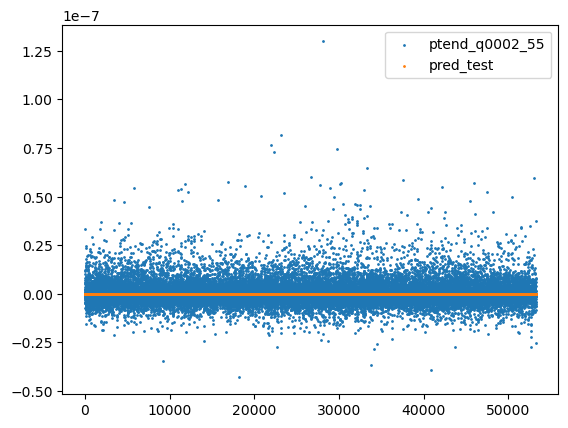

In [118]:
""" in feature space """
plt.scatter(x=range(train.shape[0]),y=train[f], s=1,label=f)
plt.scatter(x=range(train.shape[0]),y=predTrain, s=1,label='pred_train')
plt.legend()
plt.show()

plt.scatter(x=range(val.shape[0]),y=val[f], s=1,label=f)
plt.scatter(x=range(val.shape[0]),y=predVal, s=1,label='pred_test')
plt.legend()
plt.show()

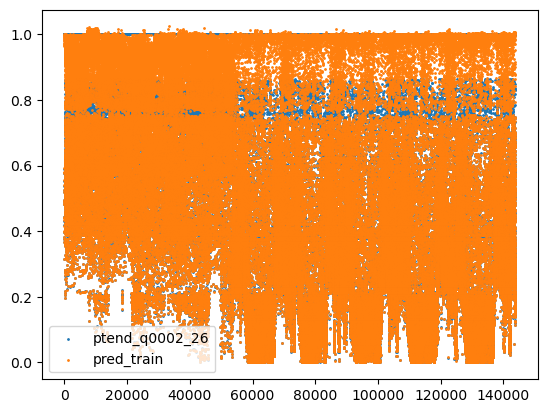

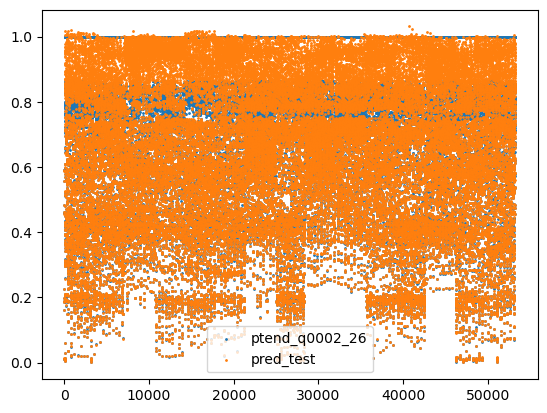

In [115]:
""" in transformed space """
plt.scatter(x=range(train.shape[0]),y=train[transfF], s=1,label=f)
plt.scatter(x=range(train.shape[0]),y=predTrain0, s=1,label='pred_train')
plt.legend()
plt.show()

plt.scatter(x=range(val.shape[0]),y=val[transfF], s=1,label=f)
plt.scatter(x=range(val.shape[0]),y=predVal0, s=1,label='pred_test')
plt.legend()
plt.show()